# 1) LIBRARIES

In [9]:
import matplotlib.pyplot as plt
import math
import random
import numpy as np
import pulp
import pandas as pd
import time
import simpy

## Loading Warhouse

5 warehouses were randomly generated before. In order to lock the warehouses, I have hard coded them. Warehouses are randomly generated from vertices and the analysis is done on these warehouse locations.

In [2]:
Wr = [(4000, 2320), (4000, 4000), (1760, 5120), (4560, 1200), (6800, 5120)]
Wr

[(4000, 2320), (4000, 4000), (1760, 5120), (4560, 1200), (6800, 5120)]

# 2) **FILES RELATED TO OPTIMISATION**

## LOADING ALL THE FUNCTIONS

### Points and Distances Function

Euclidean Distance between two points

In [10]:
def dist(p1, p2):
    (x1, y1) = p1
    (x2, y2) = p2
    return int(math.sqrt((x1-x2)**2+(y1-y2)**2))

The nearest link between two point sets

In [11]:
def nearest(X, P):
    minD = math.inf
    minP = None
    for p in P:
        for x in X:
            d=dist(x, p)
            if d<minD:
                minX, minP, minD = x, p, d
    return minX, minP         

### Graphs Function

In [12]:
def generateRandomGraph(n, x0, y0, r):

    def rounding(x):
        return int(math.floor(x/10))*10

    x0 = rounding(x0)
    y0 = rounding(y0)
    gridsize = rounding(r / math.sqrt(n) * 1.4)
    r = int(math.floor(r/gridsize))*gridsize
    split = int(2*r/gridsize)+1
    X = np.linspace(x0-r, x0+r, split)
    Y = np.linspace(y0-r, y0+r, split)
    P = [ (int(x), int(y)) for x in X for y in Y if dist((x,y), (x0,y0)) < r ]
    P = random.sample(P, k=n)
    
    E = []
    
    def addEdge(p, q):
        if p in P and q in P and (p, q) not in E and (q, p) not in E:
            E.append((p, q))
    def addDiagonalEdge(p, q):
        (xp, yp) = p
        (xq, yq) = q
        if p in P and q in P and (xp, yq) not in P and (xq, yp) not in P and (p, q) not in E and (q, p) not in E:
            E.append((p, q))
            
    for (x, y) in P:
        addEdge( (x, y), (x, y+gridsize) )
        addEdge( (x, y), (x, y-gridsize) )
        addEdge( (x, y), (x+gridsize, y) )
        addEdge( (x, y), (x-gridsize, y) )
        addDiagonalEdge( (x, y), (x+gridsize, y+gridsize) )
        addDiagonalEdge( (x, y), (x+gridsize, y-gridsize) )
        addDiagonalEdge( (x, y), (x-gridsize, y+gridsize) )
        addDiagonalEdge( (x, y), (x-gridsize, y-gridsize) )
        
    return sorted(P), sorted(E)

In [13]:
def plotGraph(P, E, col='b', grid=False):
    fig = plt.gcf()
    fig.set_size_inches(6, 6)
    if not grid:
        plt.axis('off')
    plt.plot( [ p[0] for p in P ], [ p[1] for p in P ], col+'o', lw=1, ms=3)
    for (p, q) in E:
        plt.plot( [ p[0], q[0] ], [ p[1], q[1] ], col+'-o', lw=1, ms=3)
    if grid:
        plt.grid()

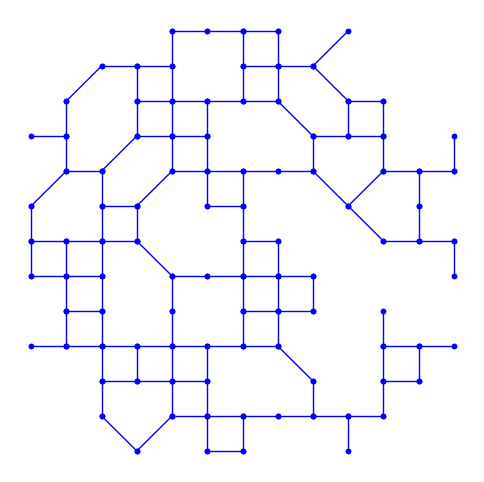

In [14]:
random.seed(3061)
V, E = generateRandomGraph(100, 5000, 5000, 4500)
plotGraph(V, E)

### Plotting Routines Function

In [15]:
import scipy.stats as stats

def histplot(data, title="", xlabel="",
             width=None, height=None):
    
    minx = min(data)
    maxx = max(data)
    μ = np.mean(data)
    σ = np.std(data)
    
    fig = plt.figure()
    fig.set_figwidth(width if width is not None else 4)
    fig.set_figheight(height if height is not None else 2.5)
    ax = fig.gca()
        
    hist=plt.hist(data, density=True)
    plt.xlabel(xlabel)
    plt.ylabel('Density')
    plt.title(title)
        
    x = np.linspace(minx, maxx, 100)
    y = [ stats.norm(loc=μ, scale=σ).pdf(p) for p in x]
    ax.plot(x, y, lw=1, color='red')
    ax.axvline(x=μ, color='red')
    maxy = max(max(y), max(hist[0]))
    ax.text(maxx, maxy, 
            f'μ={μ:2.2f}\nσ={σ:2.2f}', 
            ha='right', va='top', 
            color='red', fontsize=12)
    ax.grid(True)
    plt.show()

In [16]:
def dailyPlot(data, 
              title="", ylabel="",
              width=None, height=None):
    
    days = len(data)
    
    fig = plt.figure()
    fig.set_figwidth(width if width is not None else 6)
    fig.set_figheight(height if height is not None else 2)
    
    ax = fig.gca()
    diff = (max(data)-min(data))*0.1
    ymin = int(math.floor(min(data)-diff))
    ymax = int(math.ceil(max(data)+diff))
    ax.set_xlim(-1, days)
    ax.set_ylim(ymin, ymax)
    ax.grid(True)
    
    ms = 2 if len(data)>100 else 5
    lw = 0.5 if len(data)>100 else 1

    x = np.arange(0, len(data))
    y = np.array([ y for y in data ])
    b, m = np.polynomial.polynomial.polyfit(x, y, 1)
    
    plt.plot(x, y, 'bo-', linewidth=lw, markersize=ms)
    plt.plot(x, m*x+b, 'r-')
    
    plt.xlabel('Day')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

### Lists and Paths Function

In [17]:
def pathLength(P):
    return 0 if len(P)<=1 else \
            dist(P[0], P[1])+pathLength(P[1:])

In [18]:
def reverse(P):
    return [ P[-i] for i in range(1,len(P)+1) ]

In [19]:
def index(x, L):
    for i in range(len(L)):
        if x==L[i]: 
            return i
    return None

In [20]:
def addWithoutDuplicates(L, X):
    for i in range(len(X)):
        if X[i] not in L:
            L.append(X[i])
    return L

### Generate Customer Locations Function

In [21]:
def splitEdgeRandomly(V, E, s):
    A, B = s
    p = random.uniform(0.3,0.7)
    x = int(A[0]+p*(B[0]-A[0]))
    y = int(A[1]+p*(B[1]-A[1]))
    t = (x,y)
    E.remove(s) 
    E.append((A, t))
    E.append((t, B))
    V.append(t)
    return (V, E), t

In [22]:
def generateRandomTargets(V, E, n=5):
    V, E = V.copy(), E.copy()
    T = []
    # we want to ensure that the beginning of the 
    # sequence of points generated randomly stays
    # the same
    mindist = 300
    while len(T)<n:
        s = random.choice(E)
        A, B = s
        if dist(A,B)>mindist: # avoid targets placed narrowly
            (V, E), t = splitEdgeRandomly(V, E, s)
            T.append(t)
    return sorted(T)

In [23]:
def addTargets(M, T):
    V, E = M
    E = E.copy()
    V = V.copy()
    for t in T:
        minD = math.inf
        minE = None
        for e in E:
            P, Q = e
            distT = dist(P, t)+dist(t, Q)-dist(P, Q)
            if distT < minD:
                minD = distT
                minE = e
        P, Q = minE
        E.remove( (P, Q) )
        E.append( (P, t) )
        E.append( (t, Q) )
        V.append(t)
    return V, E

In [24]:
def addTargets(M, T, warehouse_location=None):
    V, E = M
    E = E.copy()
    V = V.copy()
    
    if warehouse_location is not None:
        # Add the warehouse location to the vertex set
        V.append(warehouse_location)
    
    for t in T:
        minD = math.inf
        minE = None
        for e in E:
            P, Q = e
            distT = dist(P, t) + dist(t, Q) - dist(P, Q)
            if distT < minD:
                minD = distT
                minE = e
        P, Q = minE
        E.remove((P, Q))
        E.append((P, t))
        E.append((t, Q))
        V.append(t)
    return V, E


### Generate Warehouse Locations Function

In [25]:
def generateWarehouseLocation(M):
    V, _ = M
    W = random.sample(V, k=1)[0]
    return W

In [26]:
import random

def generateWarehouseLocations(V, num_warehouses=5, seed=None):
    if seed is not None:
        random.seed(seed)
    # Randomly select warehouse locations from the vertices
    Wr = random.sample(V, k=num_warehouses)
    return Wr

### Time Handling Function

In [27]:
    def timestamp(t):
        day = int(t)//(24*3600)
        t = t - day*24*3600
        hour = int(t)//3600
        t = t - hour*3600
        mins = int(t)//60
        t = t - mins*60
        secs = int(math.floor(t))
        t = int(math.floor((t - secs)*10))
        return f"[{day:2d}] {hour:02d}:{mins:02d}:{secs:02d}.{t:1d}"

In [28]:
timestamp(24*3600*3+17*3600+615.1)

'[ 3] 17:10:15.0'

In [29]:
def nextHour(env, hour):
    beginningOfDay = int(env.now//(24*3600))*24*3600
    timeOfDay = env.now-beginningOfDay
    if hour*3600 > timeOfDay:
        return hour*3600 - timeOfDay
    else:
        return hour*3600 + 24*3600 - timeOfDay

In [30]:
def day(now):
    return int(now//(24*3600))

### Plot Map with Delivery Route Function

In [47]:
def plotMap(G, T=[], P=[], W=None,
            style='r-o', lw=1, ms=3, 
            styleT='go', msT=5,
            styleP='b-o', lwP=3, msP=1,
            stylePT='go', msPT=7,
            styleW='bo', msW=7,
            text=None, grid=False):
    fig = plt.gcf()
    fig.set_size_inches(5,5)
    V, E = G

    if not grid:
        plt.axis('off')
    plt.plot( [ p[0] for p in V ], [ p[1] for p in V ], 'ro', lw=lw, ms=ms)
    for (p, q) in E:
        plt.plot( [ p[0], q[0] ], [ p[1], q[1] ], 'r-o', lw=lw, ms=ms)
    for t in T:
        plt.plot( [ t[0] ], [ t[1] ], 
                  styleT, ms=msT)
    plt.plot( [ p[0] for p in P ],
              [ p[1] for p in P ], 
              styleP, lw=lwP, ms=msP)
    for p in P:
        if p in T:
            plt.plot( [ p[0] ], [ p[1] ], 
                      stylePT, ms=msPT)
    if W is not None:
        print("Warehouse locations:", W)  # Debugging statement
        plt.plot( [ w[0] for w in W ], [ w[1] for w in W ],  # Modified line
                      styleW, ms=msW)
    if text is not None:
        minX = min([p[0] for p in V])
        plt.text(minX, 0, text)
    if grid:
        plt.grid()
    plt.show()

### Generate Data Function

In [32]:
def generateData(seed=None, nodes=100, customers=50, 
                 plot=False, log=False):

    if seed is None:

        print("Usage:  M, C = generateData(seed=None, ")
        print("                            nodes=100, customers=50, ")
        print("                            plot=False, log=False)")
        print("")
        print("  seed  the seed value to be used for data generation. ")
        print("        To test the application use seed=0, it will create")
        print("        a small map, with a very few customer locations and")
        print("        a small set of delivery data.")
        print("")
        print("  nodes the number of intersections (vertices) in the generated map")
        print("")
        print("  customers  the number of customers generated on the map")
        print("")
        print("  log   Controls print output during data generation.")
        print("")
        print("  plot  Controls graphical output during data generation.")
        print("")
        print("Returns:")
        print("")
        print("  M = (V, E) is the generated map given as a graph")
        print("    where V is a list of vertices, with each vertice ")
        print("    given as a pair (x, y) of integer coordinates, ")
        print("    and E is a list of edges, with each edge given")
        print("    as a pair (A, B) of vertices, with each vertex again")
        print("    given as a pair (x, y) of integer coordinates")
        print("")
        # print("  W ∈ V  is the location of the distribution warehouse")
        # print("    given as a pair (x, y) of integer coordinates")
        # print("")
        print("  C is a list of customer locations")
        print("    given as pairs (x, y) of integer coordinates on or near")
        print("    existing edges E. To integrate a set of customer locations")
        print("    into a given map M = (V, E), use addTarget(M, C)")
        print("")
        
        seed = 0
    
    if seed==0:          # generate very simple test data 
        nodes = 20       # number of points in map
        customers = 5    # number of  customers
        grid = True
    
    elif seed == 1:
        nodes = 20
        customers = 10
        grid = True
    
    elif seed == 2:
        nodes = 20
        customers = 20
        grid = True
            
    else:
        grid = False
        
    random.seed(seed)
    
    # Calculate the maximum possible number of points based on the specified range and grid size
    max_possible_nodes = ((4000 * 2) // 5) ** 2  # Assuming grid size of 6 and range of 4000
    nodes = min(nodes, max_possible_nodes)  # Ensure nodes does not exceed the maximum possible nodes
    
    V, E = generateRandomGraph(nodes, 4000, 4000, 4000)
    
    C = generateRandomTargets(V, E, customers)

    if log:
        print(f"Generated map with {nodes:d} nodes and " 
              f"{customers:d} customer locations")
    if plot:
        label="" if seed==0 else f"seed={seed:4d}"
        plotMap((V, E), T=C, text=label, grid=grid)
    
    return (V, E), C

Data Generation is reproducible

In [33]:
D1 = generateData(3061)
D2 = generateData(3061)
D1 == D2

True

### Generate Delivery Data Function

In [34]:
def generateDeliveryData(p, C, days, seed=0):
    ## p is the average number of parcels per day per customer
    ## C is the number of customers to be served
    ## days is the number of days for which data are to be generated.
    np.random.seed(seed)
    R = np.random.poisson(lam=C*p, size=days)
    D = [ sorted(list(np.random.choice(range(C), size=i))) for i in R ]
    return D

### Finding Shortest Path Function

A* Algorithm

In [35]:
def pathLength(P):
    return 0 if len(P)<=1 else \
            dist(P[0], P[1])+pathLength(P[1:])

In [36]:
def shortestPath(M, A, B):

    def h(p): 
        return pathLength(p)+dist(p[-1],B)
    
    # candidates C are pairs of the path so far and 
    # the heuristic function of that path, 
    # sorted by the heuristic function, as maintained by
    # insert function
    def insert(C, p):
        hp = h(p)
        c = (p, hp)
        for i in range(len(C)):
            if C[i][1]>hp:
                return C[:i]+[c]+C[i:]
        return C+[c]   
        
    V, E = M
    assert(A in V and B in V)    
    C = insert([], [A])

    while len(C)>0:
        # take the first candidate out of the list of candidates
        path, _ = C[0]
        C = C[1:]
        if path[-1]==B:
            return path
        else:
            for (x, y) in E:
                if path[-1]==x and y not in path:
                    C = insert(C, path+[y])
                elif path[-1]==y and x not in path:
                    C = insert(C, path+[x])
    return None

### Iterative Integer Programing Function

In [37]:
def createTables(M, T):

    def reverse(P):
        return [ P[-i] for i in range(1,len(P)+1) ]
    
    def index(x, L):
        for i in range(len(L)):
            if x==L[i]: 
                return i
        return None

    n = len(T)
    d = [ [ math.inf for t in T ] for t in T ]
    p = [ [ None for t in T ] for t in T ]
    for i in range(n):
        d[i][i] = 0
        p[i][i] = [ T[i] ]
    for i in range(n):
        for j in range(n):
            if p[i][j] is None:
                s = shortestPath(M, T[i], T[j])
                d[i][j] = d[j][i] = pathLength(s)
                p[i][j] = s
                p[j][i] = reverse(s)
                for m in range(len(s)-1):
                    smi = index(s[m], T)
                    if smi is None:
                        continue
                    for l in range(m+1, len(s)):
                        sli = index(s[l], T)
                        if sli is None:
                            continue  
                        sub = s[m:l+1]
                        if p[smi][sli] is None:
                            p[smi][sli] = sub
                            p[sli][smi] = reverse(sub)
                            d[smi][sli] = d[sli][smi] = pathLength(sub)
    return d,p               

In [38]:
def roundtrips(x, n):
    
    def isElem(x, l):
        for i in range(len(l)):
            if l[i]==x:
                return True
        return False

    def startpoint(trips):
        for i in range(n):
            for t in trips:
                if isElem(i, t):
                    break
            else:
                return i
    
    def totalLength(trips):
        s=0
        for i in range(0, len(trips)):
            s += len(trips[i])-1
        return s

    trips = []
    while totalLength(trips)<n:
        start = startpoint(trips)
        trip = [ start ]
        i = start
        while len(trip) < n-totalLength(trips):
            for j in range(0, n):
                if pulp.value(x[i][j])==1:
                    trip.append(j)
                    i=j
                    break        
            if pulp.value(x[trip[-1]][start])==1:
                trip.append(start)
                break
        trips.append(trip)
    return sorted(trips, key=lambda t: len(t), reverse=True)

In [39]:
import time

def createLoop(M, T, timing=False):
    
    if timing:
        start_time = time.time()
        last_time = time.time()
        
    D, P = createTables(M, T)   # These are the distances between customers and warehouse only
    
    if timing:
        print(f"createTables:   {time.time()-start_time:6.2f}s")
        last_time = time.time()
        
    n = len(T)

    if n==1:
        return T
        
    # create variables
    x = pulp.LpVariable.dicts("x", ( range(n), range(n) ),
                            lowBound=0, upBound=1, cat=pulp.LpInteger)
    # create problem
    prob = pulp.LpProblem("Loop",pulp.LpMinimize)
    # add objective function
    prob += pulp.lpSum([ D[i][j]*x[i][j] 
                             for i in range(n) for j in range(n) ])
    # add constraints
    constraints=0
    for j in range(n):
        prob += pulp.lpSum([ x[i][j] for i in range(n) if i!=j ]) ==1
    constraints += n
    for i in range(n):
        prob += pulp.lpSum([ x[i][j] for j in range(n) if i!=j ]) ==1
    constraints += n
    for i in range(n):
        for j in range(n):
            if i!=j:
                prob += x[i][j]+x[j][i] <= 1
                constraints += 1
    # initialise solver
    solvers = pulp.listSolvers(onlyAvailable=True)
    solver = pulp.getSolver(solvers[0], msg=0)
    prob.solve(solver)

    if timing:
        print(f"Solver:         {time.time()-last_time:6.2f}s {constraints:6,d} Constraints")
        last_time = time.time()

    trips = roundtrips(x, n)
    while len(trips)>1:
        longest = max([ len(t) for t in trips ])
        for t in trips:
            if len(t)<longest:
                prob += pulp.lpSum([ x[t[i]][t[i+1]] + x[t[i+1]][t[i]]
                                        for i in range(0,len(t)-1) ]) <= len(t)-2
                constraints += 1
            else:
                longest = math.inf
        prob.solve(solver)
        
        if timing:
            print(f"Solver:         {time.time()-last_time:6.2f}s {constraints:6,d} Constraints")
            last_time = time.time()

        trips = roundtrips(x, n)
        
    trip = trips[0]
    loop = []
    for k in range(len(trip)-1):
        sub = P[trip[k]][trip[k+1]]
        loop += sub if len(loop)==0 else sub[1:]
        
    if timing:
        print(f"createLoop:     {time.time()-start_time:6.2f}s")

    return loop

### Floyd - Warshall Function

In [40]:
def FW(M):
    
    V, E = M

    n = len(V)
    d = [ [ math.inf for j in range(n) ] for i in range(n) ]
    p = [ [ None for j in range(n) ] for i in range(n) ]

    for (A, B) in E:
        a = V.index(A)
        b = V.index(B)
        d[a][b] = d[b][a] = dist(A, B)
        p[a][b] = [A, B]
        p[b][a] = [B, A]
    
    for i in range(n):
        d[i][i] = 0
        p[i][i] = [V[i]]
    
    for k in range(n):
        for i in range(n):
            for j in range(n):
                dk = d[i][k] + d[k][j]
                if d[i][j] > dk:
                    d[i][j] = dk
                    p[i][j] = p[i][k][:-1] + p[k][j]
                    
    return d, p

### Greedy Algorithm Function

In [41]:
def createLoopG(M, T, plot=False, timing=False):
    
    def makeLoop(L):
        loop = []
        for i in range(len(L)-1):
            A = L[i]
            B = L[i+1]
            a = V.index(A)
            b = V.index(B)
            sub = P[a][b]
            loop += sub if len(loop)==0 else sub[1:]
        return loop

    if timing:
        start_time = time.time()
        
    V, E = M
    D, P = FW(M)   # note these are the distances between all vertices in M (and T)
    
    if timing:
        print(f"Floyd-Warshall: {time.time()-start_time:6.2f}s")
        
    W = T[0]
    customers = T[1:]
    if len(T)==1:
        L = T
    elif len(T)<=3:
        L = T + [T[0]]
    else:
        L = T[:3]+[T[0]]
        T = T[3:]
        while len(T)>0:
            if plot:
                loop = makeLoop(L)
                plotMap(M, T=L, P=loop, w=W, 
                        grid=True, text=f"{pathLength(loop):,d}m")
            minExt = math.inf
            minInd = None
            selInd = None
            for k in range(len(T)):
                C = T[k]
                c = V.index(C)
                for i in range(0, len(L)-1):
                    A = L[i]
                    B = L[i+1]
                    a = V.index(A)
                    b = V.index(B)
                    ext = D[a][c] + D[c][b] - D[a][b]
                    if ext<minExt:
                        minExt, minInd, selInd = ext, i+1, k
            L = L[:minInd]+[T[selInd]]+L[minInd:]
            T = T[:selInd]+T[selInd+1:]
            
    if timing:
        print(f"createLoopG:    {time.time()-start_time:6.2f}s")
        
    return makeLoop(L)

### Heuristic Algorithm Function

In [42]:
def createLoopH(M, T, plot=False, timing=False):
    
    def makeLoop(L):
        loop = []
        for i in range(len(L)-1):
            A = L[i]
            B = L[i+1]
            a = V.index(A)
            b = V.index(B)
            sub = P[a][b]
            loop += sub if len(loop)==0 else sub[1:]
        return loop

    def shortcut2(roundtrip):
        # Make a copy because of in-place changes
        t = roundtrip.copy()
        for i in range(0, len(t)-1):
            for k in range(2, len(t)-i-1):
                a = dist(t[i], t[i+1])
                b = dist(t[i+k], t[i+k+1])
                c = dist(t[i], t[i+k])
                d = dist(t[i+1], t[i+k+1])
                if c+d < a+b:
                    sub = t[i+1:i+k+1]
                    sub.reverse()
                    t = t[0:i+1] + sub + t[i+k+1:]
                    return t
        return None

    def shortcut3(roundtrip):
        # Make a copy because of in-place changes
        t = roundtrip.copy()
        for i in range(0, len(t)-2):
            e = dist(t[i], t[i+1])
            f = dist(t[i+1], t[i+2])
            d = dist(t[i], t[i+2])
            for k in range(0, len(t)-1):
                if k+1 < i or i+2 < k:
                    b = dist(t[k], t[i+1])
                    c = dist(t[i+1], t[k+1])
                    a = dist(t[k], t[k+1])
                    if a + e + f > b + c + d:
                        if k+1 < i:
                            t = t[0:k+1] + [t[i+1]] + t[k+1:i+1] + t[i+2:]
                        else:
                            t = t[0:i+1] + t[i+2:k+1] + [t[i+1]] + t[k+1:]
                        return t
        return None

    if timing:
        start_time = time.time()
        
    V, E = M
    D, P = FW(M)   # Note these are the distances between all vertices in M (and T)
    
    if timing:
        print(f"Floyd-Warshall: {time.time()-start_time:6.2f}s")
        
    W = T[0]
    customers = T[1:]
    if len(T) == 1:
        L = T
    elif len(T) <= 3:
        L = T + [T[0]]
    else:
        L = T[:3] + [T[0]]
        T = T[3:]
        while len(T) > 0:
            if plot:
                loop = makeLoop(L)
                plotMap(M, T=L, P=loop, W=W, 
                        grid=True, text=f"{pathLength(loop):,d}m")
            minExt = math.inf
            minInd = None
            selInd = None
            for k in range(len(T)):
                C = T[k]
                c = V.index(C)
                for i in range(0, len(L)-1):
                    A = L[i]
                    B = L[i+1]
                    a = V.index(A)
                    b = V.index(B)
                    ext = D[a][c] + D[c][b] - D[a][b]
                    if ext < minExt:
                        minExt, minInd, selInd = ext, i+1, k
            L = L[:minInd] + [T[selInd]] + L[minInd:]
            T = T[:selInd] + T[selInd+1:]
            
    # Apply heuristic rule 2
    shortcut = shortcut2(L)
    if shortcut:
        L = shortcut
    
    # Apply heuristic rule 3
    shortcut = shortcut3(L)
    if shortcut:
        L = shortcut
            
    if timing:
        print(f"createLoopH:    {time.time()-start_time:6.2f}s")
        
    return makeLoop(L)

### Monte Carlo Function

In [43]:
def monte_carlo(M, T, warehouse_locations, k=math.inf, iterations=20, timing=False, plot=False):
    if timing:
        start_time = time.time()
    
    V, _ = M
    MT = addTargets(M, T)
    
    minL, minP, minW = math.inf, None, None
    
    for warehouse in warehouse_locations:
        for _ in range(iterations):
            MT_with_warehouse = addTargets(M, T, warehouse)
            
            # Generate initial solution using greedy algorithm
            P = createLoopG(MT_with_warehouse, [warehouse]+T)
            
            # Apply heuristic to optimize the solution
            P = createLoopH(MT_with_warehouse, P)
            
            L = pathLength(P)
            if L < minL:
                minL, minP, minW = L, P, warehouse
                print(f"pathlength: {L:6,d}m")
            
            if timing:
                print(f"Iteration: {_}, Time: {time.time() - start_time:6.2f}s")
        print(f"Warehouse {warehouse}")

    print("Warehouse locations:", warehouse_locations)
    print("Minimum warehouse:", minW)
    print("Minimum path:", minP)
    
    plotMap(MT, T=T, W=[minW], P=minP, text=f"Path Length={minL:8.1f}m")
    
    if timing:
        print(f"Monte Carlo runtime: {time.time() - start_time:6.2f}s")
    
    return minW


# 3) FINDING OPTIMISED WAREHOUSE LOCATION

## Importing Pickle File

In [44]:
import pickle
with open('realdata.pickled', 'rb') as f:
    Mr, Cr = pickle.load(f)

In [45]:
Wr = [(4000, 2320), (4000, 4000), (1760, 5120), (4560, 1200), (6800, 5120)]
Wr

[(4000, 2320), (4000, 4000), (1760, 5120), (4560, 1200), (6800, 5120)]

## Delivery to 10 Customers

Warehouse 1: (4000, 2320)
Optimal Path Length: 27,536 meters
Greedy Path Length: 29,315 meters
Heuristic Path Length: 28,575 meters
Warehouse locations: [(4000, 2320)]


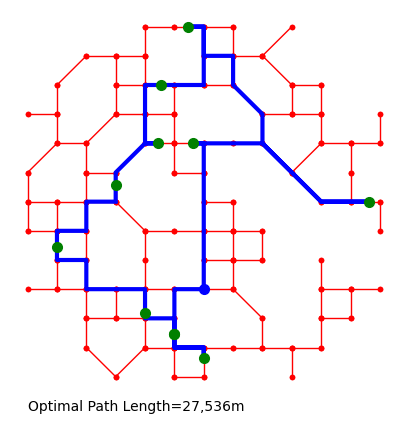

Warehouse locations: [(4000, 2320)]


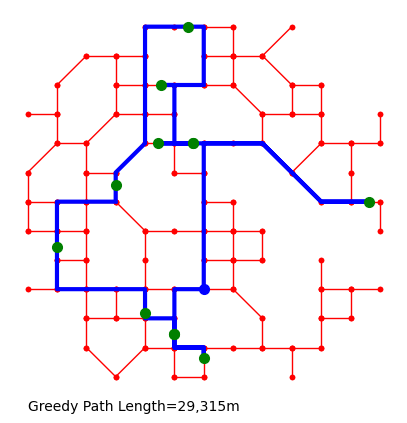

Warehouse locations: [(4000, 2320)]


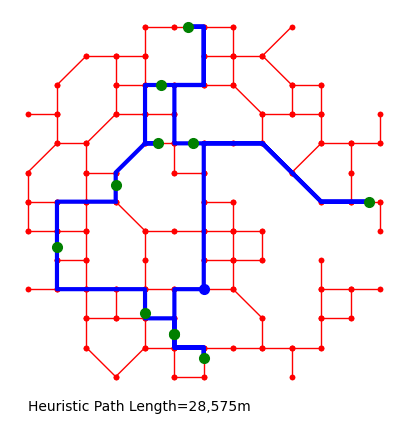

Warehouse 2: (4000, 4000)
Optimal Path Length: 27,536 meters
Greedy Path Length: 30,446 meters
Heuristic Path Length: 32,807 meters
Warehouse locations: [(4000, 4000)]


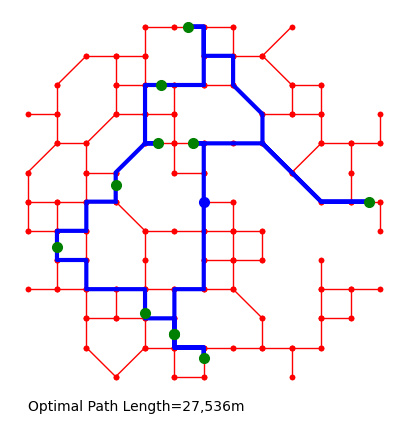

Warehouse locations: [(4000, 4000)]


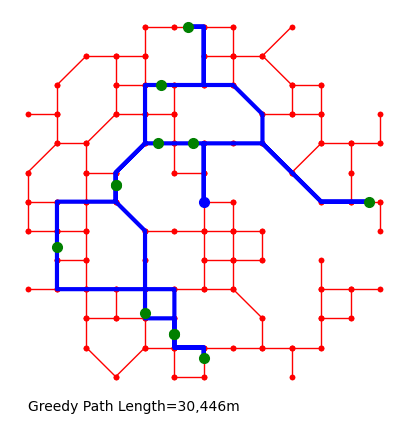

Warehouse locations: [(4000, 4000)]


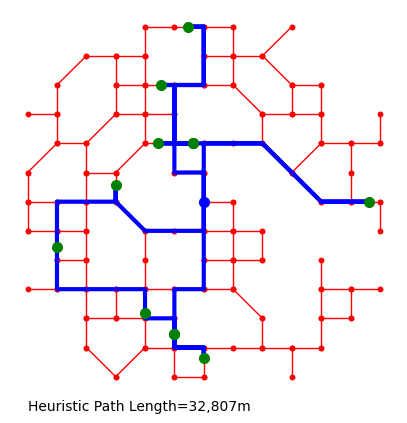

Warehouse 3: (1760, 5120)
Optimal Path Length: 28,206 meters
Greedy Path Length: 28,206 meters
Heuristic Path Length: 29,326 meters
Warehouse locations: [(1760, 5120)]


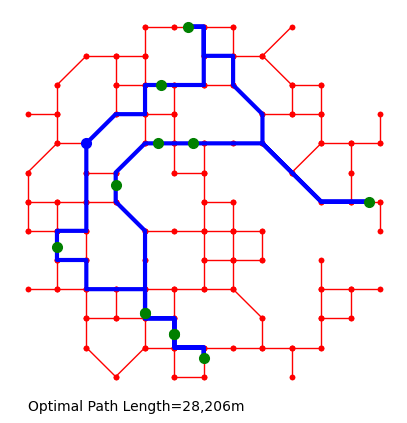

Warehouse locations: [(1760, 5120)]


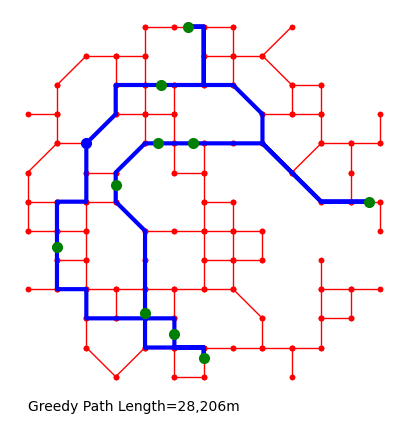

Warehouse locations: [(1760, 5120)]


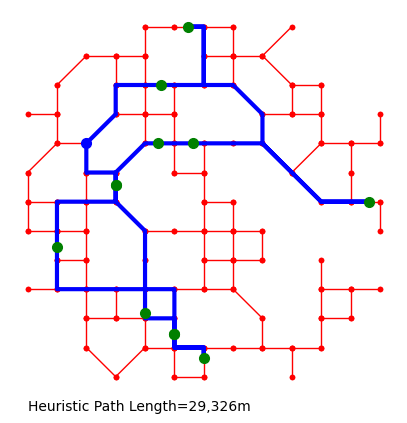

Warehouse 4: (4560, 1200)
Optimal Path Length: 28,327 meters
Greedy Path Length: 30,106 meters
Heuristic Path Length: 29,366 meters
Warehouse locations: [(4560, 1200)]


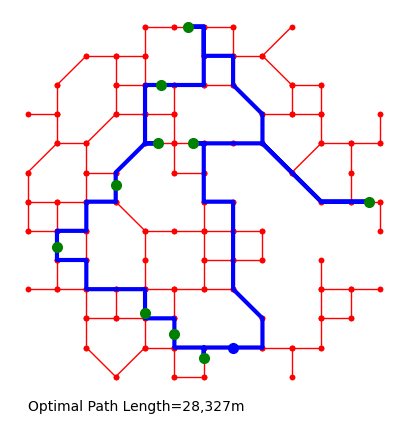

Warehouse locations: [(4560, 1200)]


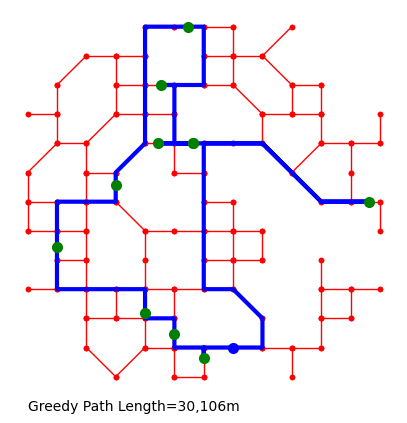

Warehouse locations: [(4560, 1200)]


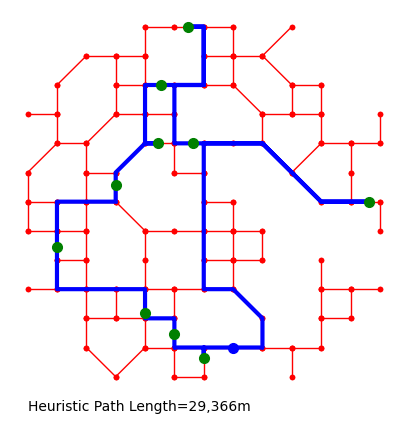

Warehouse 5: (6800, 5120)
Optimal Path Length: 28,194 meters
Greedy Path Length: 29,326 meters
Heuristic Path Length: 28,194 meters
Warehouse locations: [(6800, 5120)]


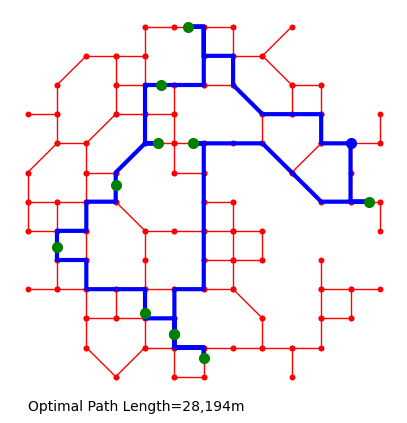

Warehouse locations: [(6800, 5120)]


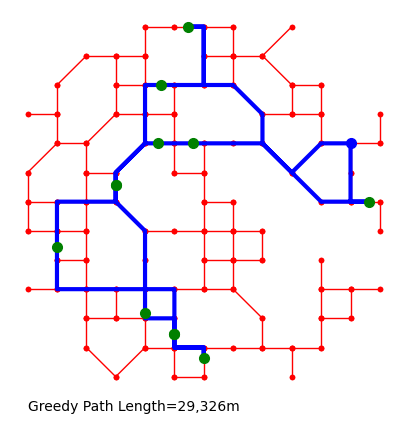

Warehouse locations: [(6800, 5120)]


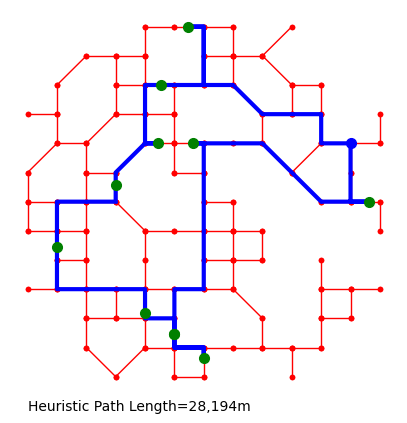

In [48]:
random.seed(0)
T = random.sample(Cr, k=10)

for idx, warehouse in enumerate(Wr, start=1):
    MC = addTargets(Mr, T)
    
    # Optimal path
    P = createLoop(MC, [warehouse]+T)
    
    # Greedy path
    PG = createLoopG(MC, [warehouse]+T)
    
    # Heuristic path
    PH = createLoopH(MC, [warehouse]+T)
    
    # Comparing path lengths
    optimal_length = pathLength(P)
    greedy_length = pathLength(PG)
    heuristic_length = pathLength(PH)
    
    # Output section header
    print(f"Warehouse {idx}: {warehouse}")
    
    # Output path lengths
    print(f"Optimal Path Length: {optimal_length:,d} meters")
    print(f"Greedy Path Length: {greedy_length:,d} meters")
    print(f"Heuristic Path Length: {heuristic_length:,d} meters")
    
    # Plotting the paths
    plotMap(MC, T=T, W=[warehouse], P=P, text=f"Optimal Path Length={optimal_length:,d}m")
    plotMap(MC, T=T, W=[warehouse], P=PG, text=f"Greedy Path Length={greedy_length:,d}m")
    plotMap(MC, T=T, W=[warehouse], P=PH, text=f"Heuristic Path Length={heuristic_length:,d}m")


## *Comparing Path Lengths - 10 Customers*

In [49]:
random.seed(0)
T = random.sample(Cr, k=10)

data = []

for idx, warehouse in enumerate(Wr, start=1):
    MC = addTargets(Mr, T)
    
    # Optimal path
    P = createLoop(MC, [warehouse]+T)
    
    # Greedy path
    PG = createLoopG(MC, [warehouse]+T)
    
    # Heuristic path
    PH = createLoopH(MC, [warehouse]+T)
    
    # Comparing path lengths
    optimal_length = pathLength(P)
    greedy_length = pathLength(PG)
    heuristic_length = pathLength(PH)
    
    data.append({
        'Warehouse Location': warehouse,
        'Optimal Path Length': optimal_length,
        'Greedy Path Length': greedy_length,
        'Heuristic Path Length': heuristic_length
    })

# Create DataFrame
df = pd.DataFrame(data)

# Set Warehouse Location as index
df.set_index('Warehouse Location', inplace=True)

# Display DataFrame
print(df)


                    Optimal Path Length  Greedy Path Length  \
Warehouse Location                                            
(4000, 2320)                      27536               29315   
(4000, 4000)                      27536               30446   
(1760, 5120)                      28206               28206   
(4560, 1200)                      28327               30106   
(6800, 5120)                      28194               29326   

                    Heuristic Path Length  
Warehouse Location                         
(4000, 2320)                        28575  
(4000, 4000)                        32807  
(1760, 5120)                        29326  
(4560, 1200)                        29366  
(6800, 5120)                        28194  


## Delivery to 20 customers

Warehouse 1: (4000, 2320)
Optimal Path Length: 36,219 meters
Greedy Path Length: 43,342 meters
Heuristic Path Length: 45,447 meters
Warehouse locations: [(4000, 2320)]


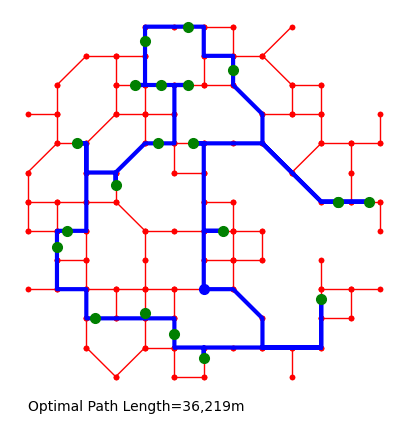

Warehouse locations: [(4000, 2320)]


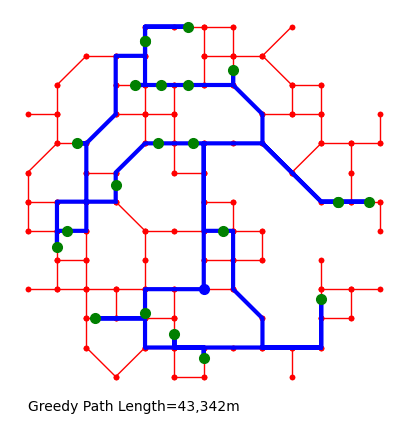

Warehouse locations: [(4000, 2320)]


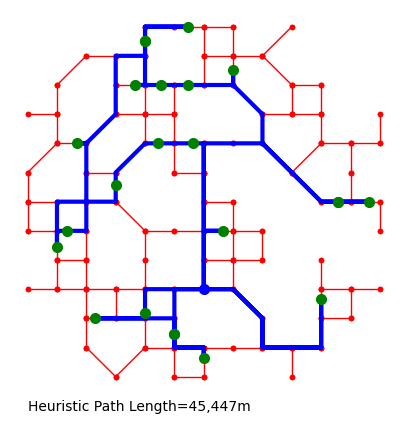

Warehouse 2: (4000, 4000)
Optimal Path Length: 35,489 meters
Greedy Path Length: 41,006 meters
Heuristic Path Length: 40,636 meters
Warehouse locations: [(4000, 4000)]


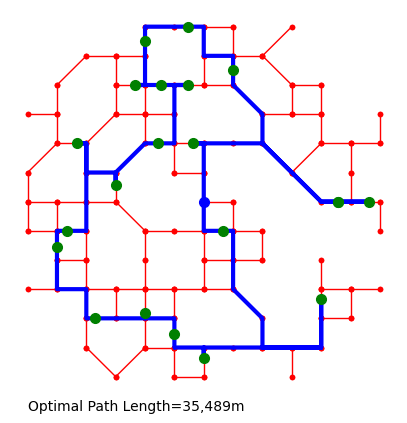

Warehouse locations: [(4000, 4000)]


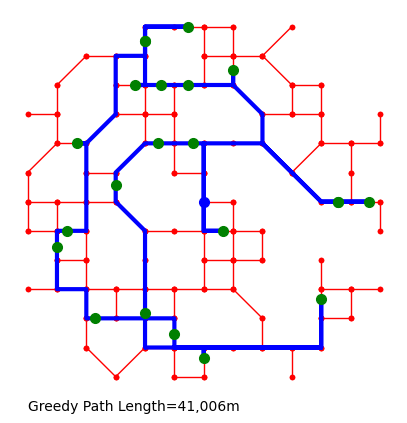

Warehouse locations: [(4000, 4000)]


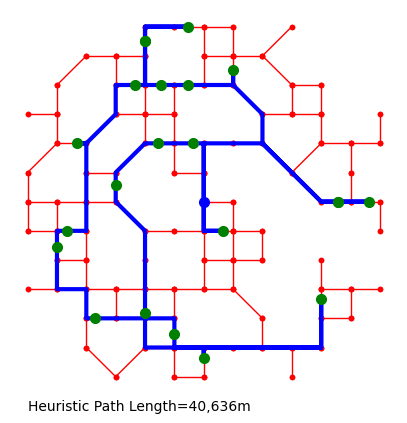

Warehouse 3: (1760, 5120)
Optimal Path Length: 35,489 meters
Greedy Path Length: 40,626 meters
Heuristic Path Length: 40,887 meters
Warehouse locations: [(1760, 5120)]


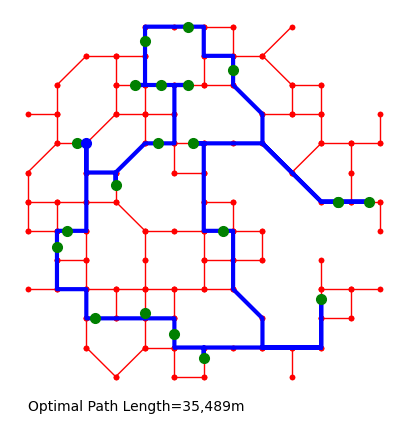

Warehouse locations: [(1760, 5120)]


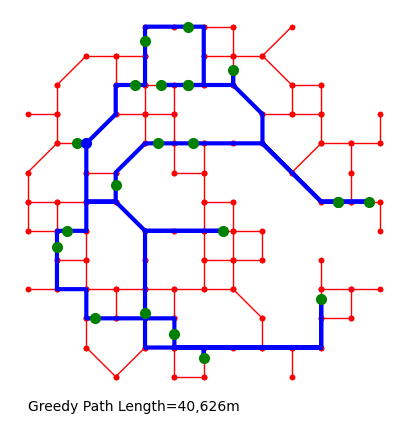

Warehouse locations: [(1760, 5120)]


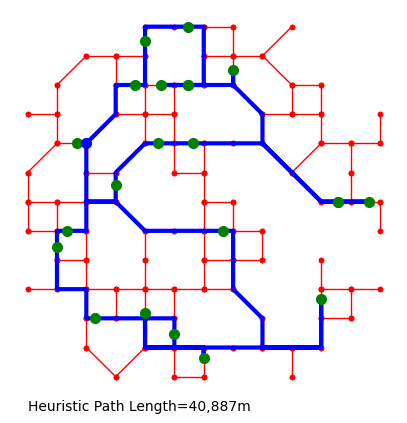

Warehouse 4: (4560, 1200)
Optimal Path Length: 35,489 meters
Greedy Path Length: 36,563 meters
Heuristic Path Length: 42,512 meters
Warehouse locations: [(4560, 1200)]


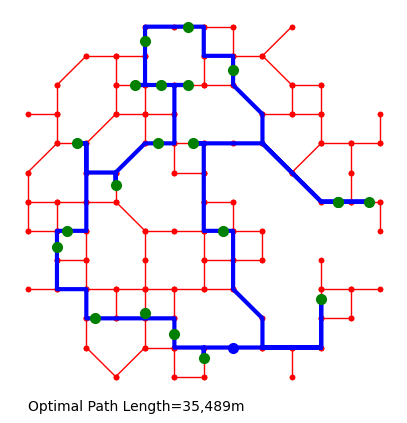

Warehouse locations: [(4560, 1200)]


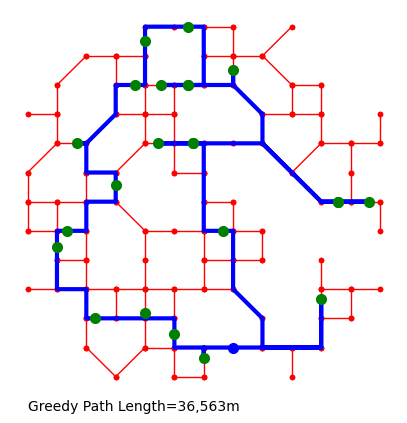

Warehouse locations: [(4560, 1200)]


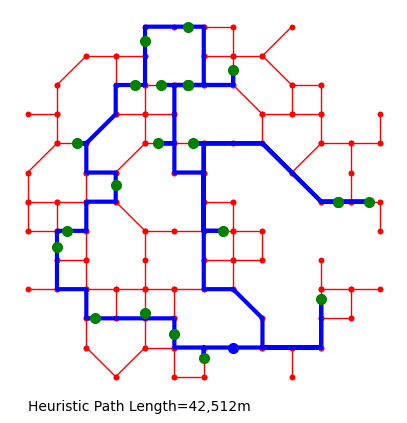

Warehouse 5: (6800, 5120)
Optimal Path Length: 36,147 meters
Greedy Path Length: 41,006 meters
Heuristic Path Length: 40,174 meters
Warehouse locations: [(6800, 5120)]


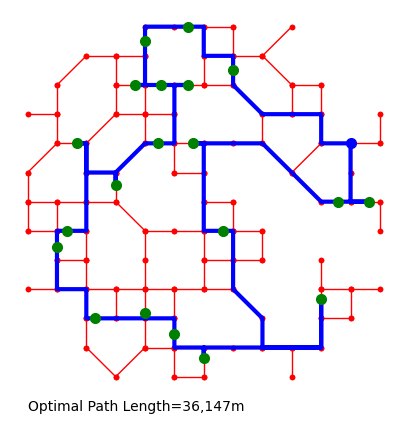

Warehouse locations: [(6800, 5120)]


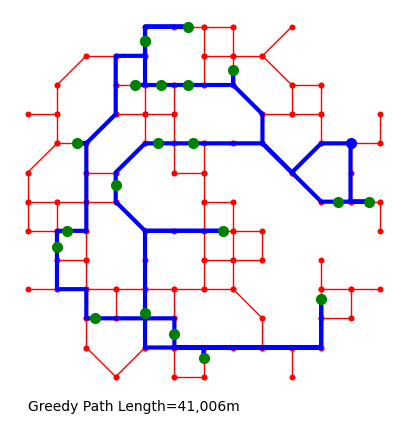

Warehouse locations: [(6800, 5120)]


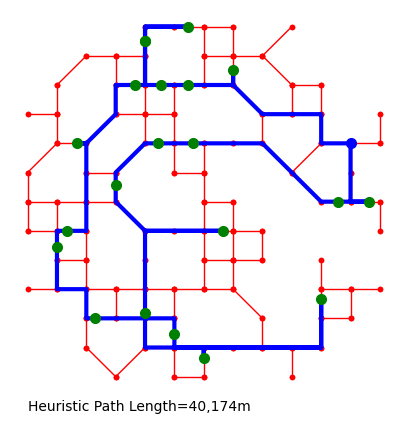

In [50]:
random.seed(0)
T = random.sample(Cr, k=20)

for idx, warehouse in enumerate(Wr, start=1):
    MC = addTargets(Mr, T)
    
    # Optimal path
    P = createLoop(MC, [warehouse]+T)
    
    # Greedy path
    PG = createLoopG(MC, [warehouse]+T)
    
    # Heuristic path
    PH = createLoopH(MC, [warehouse]+T)
    
    # Comparing path lengths
    optimal_length = pathLength(P)
    greedy_length = pathLength(PG)
    heuristic_length = pathLength(PH)
    
    # Output section header
    print(f"Warehouse {idx}: {warehouse}")
    
    # Output path lengths
    print(f"Optimal Path Length: {optimal_length:,d} meters")
    print(f"Greedy Path Length: {greedy_length:,d} meters")
    print(f"Heuristic Path Length: {heuristic_length:,d} meters")
    
    # Plotting the paths
    plotMap(MC, T=T, W=[warehouse], P=P, text=f"Optimal Path Length={optimal_length:,d}m")
    plotMap(MC, T=T, W=[warehouse], P=PG, text=f"Greedy Path Length={greedy_length:,d}m")
    plotMap(MC, T=T, W=[warehouse], P=PH, text=f"Heuristic Path Length={heuristic_length:,d}m")


## *Comparing Path Lengths - 20 Customers*

In [51]:
random.seed(0)
T = random.sample(Cr, k=20)

data = []

for idx, warehouse in enumerate(Wr, start=1):
    MC = addTargets(Mr, T)
    
    # Optimal path
    P = createLoop(MC, [warehouse]+T)
    
    # Greedy path
    PG = createLoopG(MC, [warehouse]+T)
    
    # Heuristic path
    PH = createLoopH(MC, [warehouse]+T)
    
    # Comparing path lengths
    optimal_length = pathLength(P)
    greedy_length = pathLength(PG)
    heuristic_length = pathLength(PH)
    
    data.append({
        'Warehouse Location': warehouse,
        'Optimal Path Length': optimal_length,
        'Greedy Path Length': greedy_length,
        'Heuristic Path Length': heuristic_length
    })

# Create DataFrame
df = pd.DataFrame(data)

# Set Warehouse Location as index
df.set_index('Warehouse Location', inplace=True)

# Display DataFrame
print(df)


                    Optimal Path Length  Greedy Path Length  \
Warehouse Location                                            
(4000, 2320)                      36219               43342   
(4000, 4000)                      35489               41006   
(1760, 5120)                      35489               40626   
(4560, 1200)                      35489               36563   
(6800, 5120)                      36147               41006   

                    Heuristic Path Length  
Warehouse Location                         
(4000, 2320)                        45447  
(4000, 4000)                        40636  
(1760, 5120)                        40887  
(4560, 1200)                        42512  
(6800, 5120)                        40174  


## Delivery to All Customers

Warehouse 1: (4000, 2320)
Optimal Path Length: 46,847 meters
Greedy Path Length: 52,555 meters
Heuristic Path Length: 55,713 meters
Warehouse locations: [(4000, 2320)]


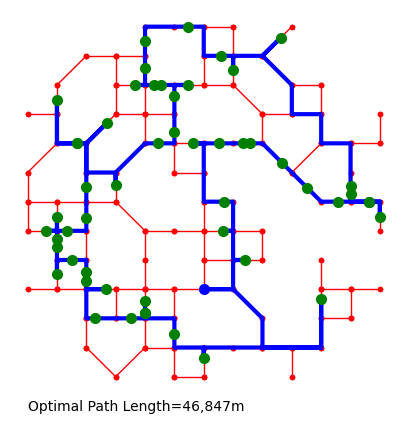

Warehouse locations: [(4000, 2320)]


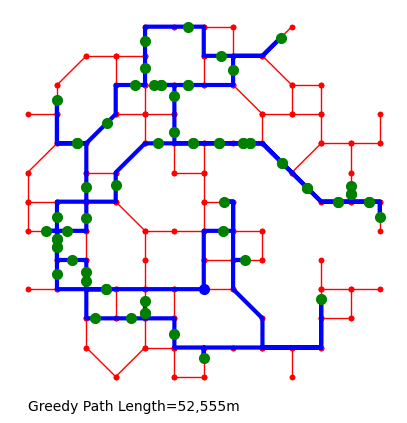

Warehouse locations: [(4000, 2320)]


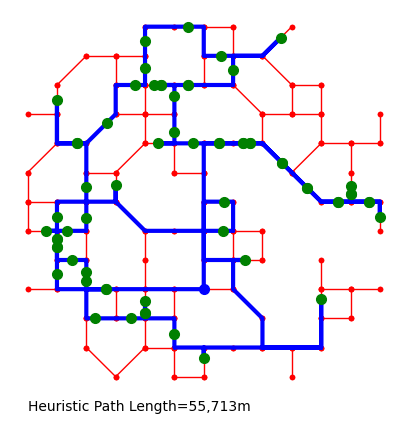

Warehouse 2: (4000, 4000)
Optimal Path Length: 45,727 meters
Greedy Path Length: 48,822 meters
Heuristic Path Length: 48,822 meters
Warehouse locations: [(4000, 4000)]


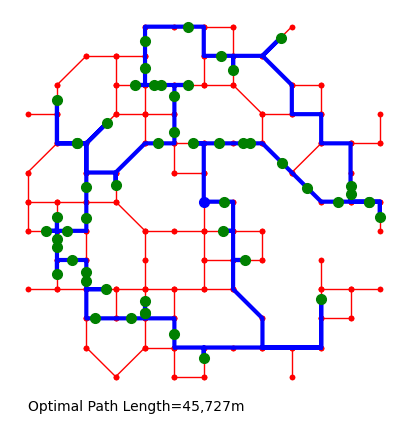

Warehouse locations: [(4000, 4000)]


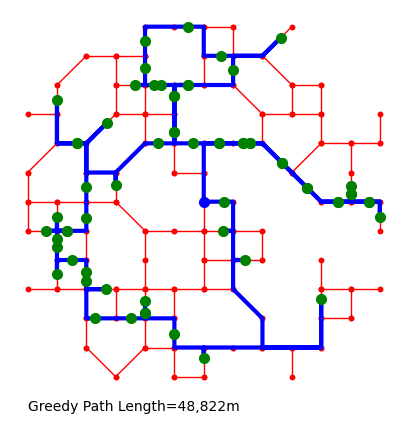

Warehouse locations: [(4000, 4000)]


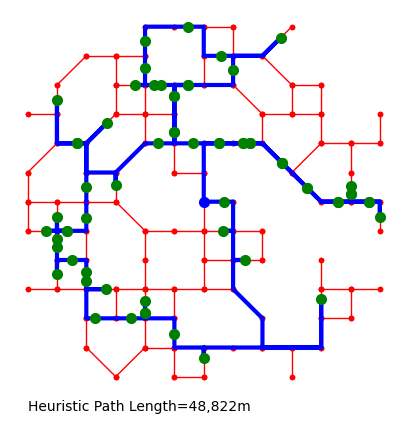

Warehouse 3: (1760, 5120)
Optimal Path Length: 45,727 meters
Greedy Path Length: 54,830 meters
Heuristic Path Length: 54,428 meters
Warehouse locations: [(1760, 5120)]


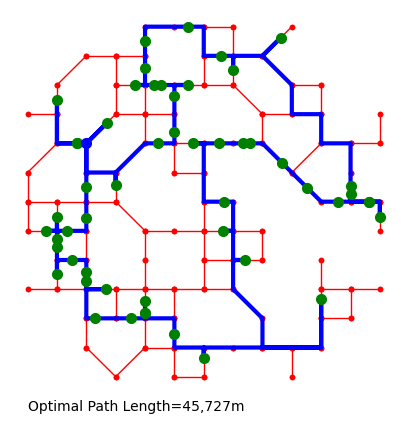

Warehouse locations: [(1760, 5120)]


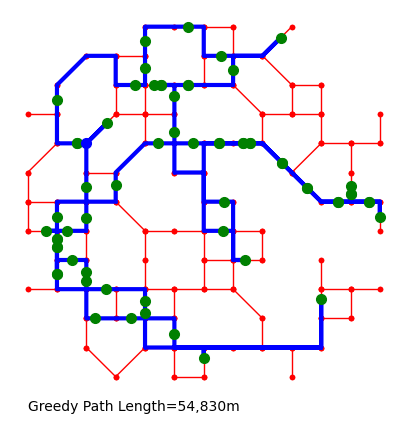

Warehouse locations: [(1760, 5120)]


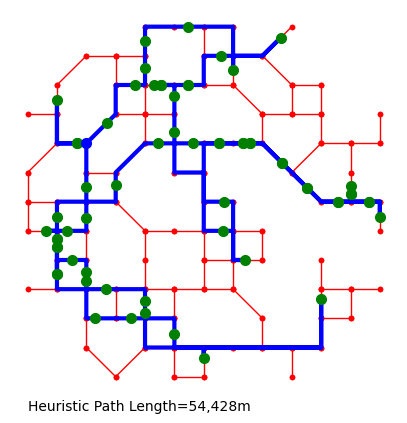

Warehouse 4: (4560, 1200)
Optimal Path Length: 45,727 meters
Greedy Path Length: 53,360 meters
Heuristic Path Length: 57,572 meters
Warehouse locations: [(4560, 1200)]


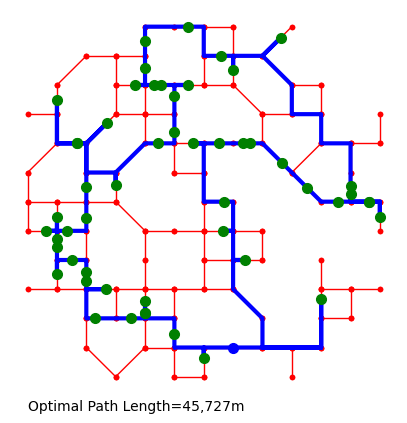

Warehouse locations: [(4560, 1200)]


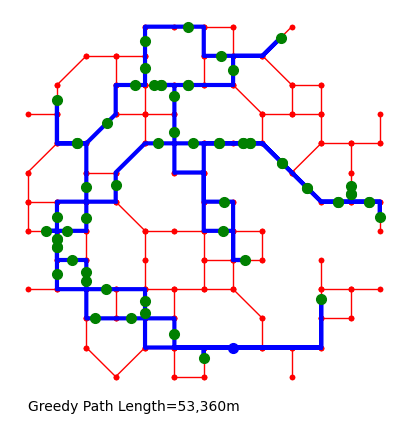

Warehouse locations: [(4560, 1200)]


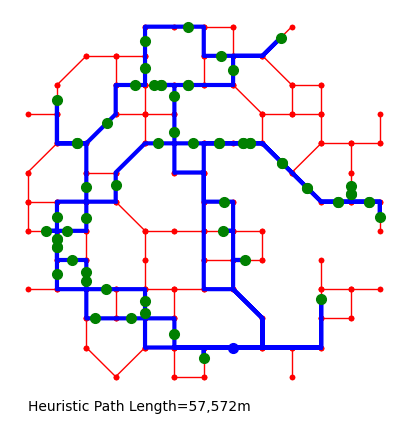

Warehouse 5: (6800, 5120)
Optimal Path Length: 45,727 meters
Greedy Path Length: 54,833 meters
Heuristic Path Length: 54,833 meters
Warehouse locations: [(6800, 5120)]


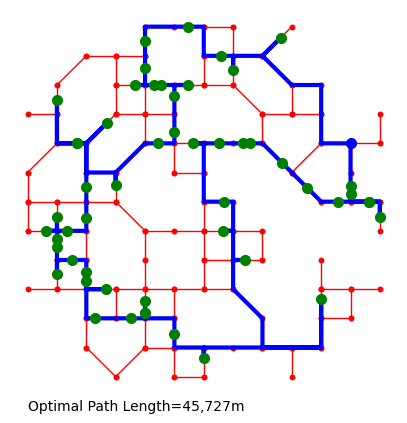

Warehouse locations: [(6800, 5120)]


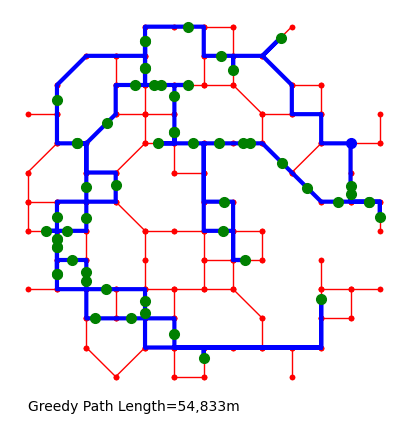

Warehouse locations: [(6800, 5120)]


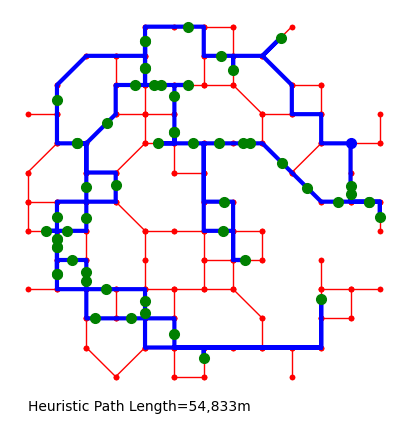

In [52]:
random.seed(0)
T = Cr

for idx, warehouse in enumerate(Wr, start=1):
    MC = addTargets(Mr, T)
    
    # Optimal path
    P = createLoop(MC, [warehouse]+T)
    
    # Greedy path
    PG = createLoopG(MC, [warehouse]+T)
    
    # Heuristic path
    PH = createLoopH(MC, [warehouse]+T)
    
    # Comparing path lengths
    optimal_length = pathLength(P)
    greedy_length = pathLength(PG)
    heuristic_length = pathLength(PH)
    
    # Output section header
    print(f"Warehouse {idx}: {warehouse}")
    
    # Output path lengths
    print(f"Optimal Path Length: {optimal_length:,d} meters")
    print(f"Greedy Path Length: {greedy_length:,d} meters")
    print(f"Heuristic Path Length: {heuristic_length:,d} meters")
    
    # Plotting the paths
    plotMap(MC, T=T, W=[warehouse], P=P, text=f"Optimal Path Length={optimal_length:,d}m")
    plotMap(MC, T=T, W=[warehouse], P=PG, text=f"Greedy Path Length={greedy_length:,d}m")
    plotMap(MC, T=T, W=[warehouse], P=PH, text=f"Heuristic Path Length={heuristic_length:,d}m")


## *Comparing Path Lengths - All Customers*

In [53]:
random.seed(0)
T = Cr

data = []

for idx, warehouse in enumerate(Wr, start=1):
    MC = addTargets(Mr, T)
    
    # Optimal path
    P = createLoop(MC, [warehouse]+T)
    
    # Greedy path
    PG = createLoopG(MC, [warehouse]+T)
    
    # Heuristic path
    PH = createLoopH(MC, [warehouse]+T)
    
    # Comparing path lengths
    optimal_length = pathLength(P)
    greedy_length = pathLength(PG)
    heuristic_length = pathLength(PH)
    
    data.append({
        'Warehouse Location': warehouse,
        'Optimal Path Length': optimal_length,
        'Greedy Path Length': greedy_length,
        'Heuristic Path Length': heuristic_length
    })

# Create DataFrame
df = pd.DataFrame(data)

# Set Warehouse Location as index
df.set_index('Warehouse Location', inplace=True)

# Display DataFrame
print(df)


                    Optimal Path Length  Greedy Path Length  \
Warehouse Location                                            
(4000, 2320)                      46847               52555   
(4000, 4000)                      45727               48822   
(1760, 5120)                      45727               54830   
(4560, 1200)                      45727               53360   
(6800, 5120)                      45727               54833   

                    Heuristic Path Length  
Warehouse Location                         
(4000, 2320)                        55713  
(4000, 4000)                        48822  
(1760, 5120)                        54428  
(4560, 1200)                        57572  
(6800, 5120)                        54833  


## MonteCarlo Optimisation

pathlength: 58,871m
Warehouse (4000, 2320)
Warehouse (4000, 4000)
Warehouse (1760, 5120)
Warehouse (4560, 1200)
Warehouse (6800, 5120)
Warehouse locations: [(4000, 2320), (4000, 4000), (1760, 5120), (4560, 1200), (6800, 5120)]
Minimum warehouse: (4000, 2320)
Minimum path: [(4000, 2320), (3440, 2320), (3440, 1760), (2880, 1760), (2880, 1860), (2880, 2093), (2880, 2320), (2320, 2320), (2132, 2320), (1760, 2320), (1760, 2473), (1760, 2646), (1760, 2880), (1492, 2880), (1200, 2880), (1200, 3123), (1200, 3276), (1200, 3440), (1398, 3440), (1760, 3440), (1760, 3677), (1760, 4000), (1760, 4282), (1760, 4560), (1760, 5120), (1574, 5120), (1200, 5120), (1200, 5680), (1200, 5946), (1200, 5680), (1200, 5120), (1574, 5120), (1760, 5120), (2151, 5511), (2320, 5680), (2880, 5680), (2880, 5120), (3131, 5120), (3440, 5120), (3795, 5120), (4000, 5120), (4288, 5120), (4560, 5120), (4754, 5120), (4889, 5120), (5120, 5120), (5489, 4750), (5680, 4560), (5971, 4268), (6240, 4000), (6552, 4000), (6800, 4000)

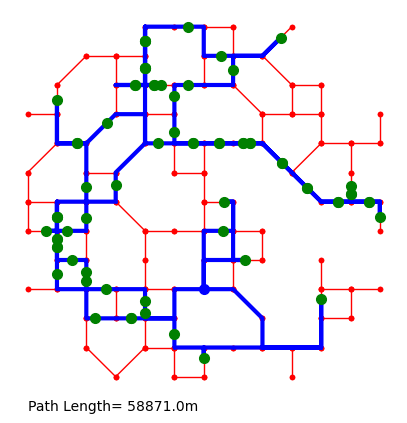

(4000, 2320)

In [54]:
monte_carlo(Mr, T, list(Wr))

# 4) FILES RELATED TO SIMULATION

## Loading Functions for Simulation

### Generating Input Data Function

In [55]:
def generateDeliveryData(p, C, days, seed=0):
    ## p is the average number of parcels per day per customer
    ## C is the number of customers to be served
    ## days is the number of days for which data are to be generated.
    np.random.seed(seed)
    R = np.random.poisson(lam=len(C)*p, size=days)
    D = [ sorted(list(np.random.choice(range(len(C)), size=i))) for i in R ]
    return D

In [56]:
def generateInputData(D, log=False):

    R = [ len(d) for d in D ]
    N = sum(R)
    
    DAY_LENGTH = 24*3600    # measured in minutes
    DAY_START = 8*3600      # first delivery in the morning
    DAY_END = 17*3600     # last delivery during day time

    x = pd.DataFrame()

    x['iarr'] = [None]*N
    x['time'] = [None]*N
    x['day'] = [None]*N
    x['dest'] = [None]*N

    current_day = 0
    last_time = 0
    i = 0

    for d in D: # for each day

        if log:
            print("generating for day: ",current_day, D[current_day])
            
        time = current_day*DAY_LENGTH + DAY_START 

        for c in d: # for each customer that should get a 

            IARR = (DAY_END-DAY_START-2*3600) / len(d)  # estimated average IAT for the current day

            iat = random.expovariate(1.0/IARR)
            new_time = time + iat

            x.at[i, 'iarr'] = round(new_time - last_time,1)
            x.at[i, 'time'] = round(new_time - current_day*DAY_LENGTH , 1)
            x.at[i, 'day'] = current_day
            x.at[i, 'dest'] = c
            
            i += 1
            last_time = time = new_time
    
        current_day += 1
    
    return x

### Loading Simulation Function

In [57]:
def simulation(M, W, C, p=0.2, days=10, seed=0, log=False, plot=False, timing=False):

#     if timing:
#         start_time = time.time()
        
    random.seed(seed)
    D = generateDeliveryData(p, C, days, seed)
    X = generateInputData(D, log=log)
    
    env = simpy.Environment()
    rec = Recorder(env, M, W, C, days, log=log, plot=plot, timing=timing)

    print(f"Simulating delivery of {len(X):d} parcels "
          f"over {len(D):d} days to {len(C):d} customers")

    for c in C:
        Customer.getCustomer(rec, c)           
    DC = DeliveryCentre(rec, M, W)
    D = Driver(rec, DC)

    def generatorProcess(env):
        # generate the parcels based on input data x
        for i in range(len(X)):
            yield env.timeout(X.at[i, 'iarr'])
            custIndex = X.at[i, 'dest']
            custLoc = C[custIndex]
            cust = Customer.getCustomer(rec, custLoc)
            p = Parcel.getParcel(rec, i, cust, custIndex)
            DC.acceptParcel(p)

    env.process(generatorProcess(env))
    env.run()

    rec.finish()

    if log:
        print(f"Delivery Centre Inventory: {DC.getInventory():d} parcels")

    return rec

## Loading all the Classes

### Class Recorder

In [58]:
class Recorder:
    
    def __init__(self, env, M, W, C, days, 
                 log=False, plot=False, timing=False):
        self.env = env
        self.M = M
        self.W = W
        self.C = C
        self.days = days
        self.log = log
        self.plot = plot
        
        self.timing = timing
        self.start_time = time.time()
        self.last_time = self.start_time
        self.cum_timer = {}

        Customer.REGISTER = []
        Parcel.REGISTER = []

        # create a data frame for records per working day
        self.daily = pd.DataFrame()
        self.daily['begin work at'] = [None]*days
        self.daily['end work at'] = [None]*days
        self.daily['dist'] = [None]*days
        self.daily['left'] = [None]*days

    def timer(self, s):
        t = time.time()
        Δt = t-self.last_time
        if self.timing:
            print(f"==== t: {t-self.start_time:6.2f}s "
                  f"Δt: {Δt:6.2f}s [{s:s}]")
        if s in self.cum_timer:
            self.cum_timer[s] += Δt
        else:
            self.cum_timer[s] = Δt
        self.last_time = t

    def reportTimer(self):
        print(f"==== t: {self.total_time:6.2f}s Total")
        for k in sorted(self.cum_timer, key=lambda x: self.cum_timer[x], reverse=True):
            print(f"==== ΣΔt: {self.cum_timer[k]:6.2f}s "+ k)

    def trace(self, event):
        if self.log:
            print(timestamp(self.env.now), event)

    def recordDriverBeginsWork(self):
        self.trace("Driver arrives for work")
        self.daily.at[day(self.env.now), 'begin work at'] = int(round(self.env.now))
        
    def recordDriverEndsWork(self):
        self.trace("Driver goes home")
        self.daily.at[day(self.env.now), 'end work at'] = int(round(self.env.now))
    
    def recordTourLength(self, length):
        self.daily.at[day(self.env.now), 'dist'] = int(length)

    def recordParcelsLeftOver(self, numberOfParcels):
        self.trace(f"{numberOfParcels:d} left over for next day")
        self.daily.at[day(self.env.now), 'left'] = numberOfParcels

    def finish(self):
        # simulation is finished for good
        # by removing the simulation environment we can
        # pickle recorder
        self.env = None
        self.total_time = time.time()-self.start_time
        self.daily['working time'] = (self.daily['end work at']-self.daily['begin work at'])//60

        
    def __stats__(self, column):
        d = self.daily[column].copy()
        return d.mean(), d.median(), d.std()
        
    def statsWorkingTime(self):
        return self.__stats__('working time')
        
    def histWorkingTime(self):
        histplot(self.daily['working time'],
                 xlabel='Working Time [min]',
                 title='Daily Working Time')
        
    def plotWorkingTime(self):
        dailyPlot(self.daily['working time'],
                  ylabel='Working Time [min]',
                  title='Daily Working Time')

    def statsTourLength(self):
        return self.__stats__('dist')
        
    def histTourLength(self):
        histplot(self.daily['dist'],
                 xlabel='Tour Length [m]',
                 title='Daily Tour Length')
            
    def plotTourLength(self):
        dailyPlot(self.daily['dist'],
                  ylabel='Tour Length [m]',
                  title='Daily Tour Length')

    def statsLeftOver(self):
        return self.__stats__('left')
        
    def histLeftOver(self):
        histplot(self.daily['left'],
                 xlabel='Left-Over Parcels',
                 title='Daily Left-Over Parcels')
                
    def plotLeftOver(self):
        dailyPlot(self.daily['left'],
                  ylabel='Number of Parcels',
                  title='Daily Left-Over Parcels')

### Class Parcel

In [59]:
class Parcel:
    
    REGISTER = []
    
    def __init__(self, rec, i, cust, custIndex):
        self.rec = rec
        self.i = i  # row index in data frames of input data
        self.dest = cust.location
        self.custIndex = custIndex
        self.status = [ 'processing' ] # status record and
        self.timing = [ self.rec.env.now ]      # timing
        assert(len(Parcel.REGISTER)==i)
        Parcel.REGISTER += [ self ] 
    
    # factory method ensures that there is only
    # one Parcel per location
    def getParcel(rec, i, location, custIndex):
        for p in Parcel.REGISTER:
            if p.i == i:
                return p
        return Parcel(rec, i, location, custIndex)

    
    def __str__(self):
        return f"Parcel: {self.i:3d} ({self.custIndex:3d})"

    def index(self):
        return self.i
    
    def destination(self):
        return self.dest
    
    def __reg(self, state):
        self.status += [ state ]
        self.timing += [ self.rec.env.now ]
        self.rec.trace(str(self)+" "+state)
        
    def arrivedAtDeliveryCentre(self):
        self.__reg('arr at delivery centre')
        
    def outForDelivery(self): 
        self.__reg('out for delivery')
        
    def returnFromDelivery(self):
        self.__reg('return from delivery')

### Class Customer

In [60]:
class Customer:
    
    REGISTER = []

    def __init__(self, rec, location):
        self.rec = rec
        self.location = location
        self.i = len(Customer.REGISTER)
        Customer.REGISTER += [ self ]
        self.atHome = True
        self.answersDoor = False
        self.parcelsReceived = []
        rec.env.process(self.process())
        
    def __str__(self):
        return f"Customer: {self.i:2d} {str(self.location):s}"
    
    # factory method ensures that there is only
    # one customer per location
    def getCustomer(rec, location):
        for c in Customer.REGISTER:
            if c.location == location:
                return c
        return Customer(rec, location)
    
    def leaveHouse(self):
        assert(self.atHome and not self.answersDoor)
        # self.rec.trace(str(self)+" leaves house")
        self.atHome = False
     
    def returnHome(self):
        assert(not self.atHome)
        # self.rec.trace(str(self)+" returns home")
        self.atHome = True
        
    def answerDoor(self):
        if self.atHome:
            yield self.rec.env.timeout(random.expovariate(1/AVERAGE_TIME_ANSWER_DOOR))
            self.rec.trace(str(self)+" answers door")
            self.answersDoor = True
        else:
            yield self.rec.env.timeout(WAIT_TIME_IF_CUSTOMER_DOESNT_ANSWER_DOOR)
            self.rec(str(self)+" not at home")
            
    def acceptParcel(self, parcel):
        assert(self.answersDoor)
        self.parcelsReceived += [parcel]
        self.rec.trace(str(self)+" accepts "+str(parcel))
        
    def signOff(self):
        assert(self.answersDoor)
        self.rec.trace(str(self)+" signs off")
        self.answersDoor = False
        
    def process(self):
        yield self.rec.env.timeout(nextHour(self.rec.env, 8))
        while day(self.rec.env.now)<self.rec.days:
            # in a refinement we may use random times
            self.leaveHouse()
            yield self.rec.env.timeout(nextHour(self.rec.env, 18))
            self.returnHome()
            yield self.rec.env.timeout(nextHour(self.rec.env, 8))

### Class Driver

In [61]:
class Driver:
    
    def __init__(self, rec, DC):
        self.rec = rec
        self.DC = DC
        self.location = None
        self.parcels = None
        self.tour = None
        self.rec.env.process(self.process())
        
    # activity
    def __drive(self, target):
        assert(self.tour[0] == self.location)
        while self.location!=target:
            d = dist(self.location, self.tour[1])
            yield self.rec.env.timeout(d / AVERAGE_SPEED)
            self.location = self.tour[1]
            self.tour = self.tour[1:]
        assert(self.tour[0] == self.location == target)
    
    def arriveForWork(self):
        self.location = self.DC.W
        self.parcels = []
        self.returns = []
        self.tour = [ self.DC.W ]
        self.rec.recordDriverBeginsWork()
        
    def leaveForDelivery(self, tour, parcels):
        self.tour, self.parcels = tour, parcels
        self.rec.trace(f"Driver leaves for delivery " \
                       f"of {len(parcels):d} parcels")
        
    def process(self):
        yield self.rec.env.timeout(nextHour(self.rec.env, 18))
        while day(self.rec.env.now)<self.rec.days:
            self.arriveForWork()
            tour, parcels = self.DC.sendForDelivery()
            yield self.rec.env.timeout(PREP_TIME_PER_PARCEL*len(parcels))
            self.rec.recordTourLength(pathLength(tour))
            self.leaveForDelivery(tour, parcels)        
            while len(self.parcels)>0:
                # drive to customer
                custLocation = self.parcels[0].dest
                cust = Customer.getCustomer(self.rec, custLocation)
                self.rec.trace("Driver drives to "+str(cust))
                yield from self.__drive(custLocation)
                self.rec.trace("Driver arrived at "+str(cust))
                # call at customer
                yield from cust.answerDoor()
                
                if cust.answersDoor:
                    while len(self.parcels)>0 and \
                            custLocation == self.parcels[0].dest:
                        cust.acceptParcel(self.parcels[0])
                        yield self.rec.env.timeout(random.expovariate(1/10))
                        self.parcels = self.parcels[1:]
                    cust.signOff()
                    yield self.rec.env.timeout(random.expovariate(1/10))
                else:
                    while len(self.parcels)>0 and  \
                            custLocation == self.parcels[0].dest:
                        self.returns += self.parcels[0]
                        self.parcels = self.parcels[1:]

            # return to delivery centre
            self.rec.trace("Driver returns to delivery centre")
            yield from self.__drive(self.DC.W)
            self.rec.trace("Driver arrived at delivery centre")
            
            for parcel in self.returns:
                self.DC.returnFromDelivery(parcel)
                yield self.rec.env.timeout(RETURN_TIME_PER_PARCEL)
            yield self.rec.env.timeout(600)
                    
            self.rec.recordParcelsLeftOver(len(self.DC.parcels)+
                                           len(self.DC.leftOver))

            self.rec.recordDriverEndsWork()
            
            yield self.rec.env.timeout(nextHour(self.rec.env, 18))

### Class Delivery Center

In [62]:
class DeliveryCentre:
    
    def __init__(self, rec, M, W):
        self.rec = rec
        self.M = M
        self.W = W
        self.limit = 35000
        
        self.leftOver = []    # list of parcels
        self.parcels = []     # list of parcels scheduled for delivery
        self.dest = []        # list of unique customer destinations
        self.tour = None      # tour planned for delivery
    
    def __accept(self, parcel):
        custLoc = parcel.dest
        if custLoc not in self.dest:
            MT = addTargets(self.M, self.dest + [custLoc])
            self.rec.timer("addTarget")
            SH = createLoopH(MT, [self.W] + self.dest + [custLoc], 
                             timing=self.rec.timing)
            self.rec.timer("createLoopH")
            if self.tour is None and pathLength(SH)<self.limit:
                self.parcels.append(parcel)
                self.dest += [custLoc]
            else: 
                S = createLoop(MT, [self.W] + self.dest + [custLoc], 
                               timing=self.rec.timing)
                self.rec.timer("createLoop")
                if pathLength(S)<self.limit:
                    self.parcels.append(parcel)
                    self.dest += [custLoc]
                    self.tour = S
                else:
                    self.leftOver.append(parcel)
        else:
            self.parcels.append(parcel)
        
    def acceptParcel(self, parcel):
        parcel.arrivedAtDeliveryCentre()
        self.__accept(parcel)
            
    def sendForDelivery(self):
        parcels = []
        if self.tour is None:
            MT = addTargets(self.M, self.dest)
            self.rec.timer("addTarget")
            self.tour = createLoop(MT, [self.W] + self.dest, 
                                   timing=self.rec.timing)
            self.rec.timer("createLoop")
        tour = self.tour
        addresses = self.dest
        
        # pick parcels in sequence to be delivered
        for i in range(1, len(tour)-1):
            dest = tour[i]
            for p in self.parcels:
                if p.dest == dest and p not in parcels:
                    parcels += [p]
                    p.outForDelivery()
         
        # arrange the left overs
        L = self.leftOver
        self.tour = None
        self.parcels = []
        self.leftOver = []
        self.dest = []
        for p in L:
            self.__accept(p)
        
        if self.rec.plot:
            plotMap(self.rec.M, T=addresses, P=tour, W=tour[0], 
                    text=f"Day {day(self.rec.env.now):2d}, {pathLength(tour):,d}m")

        return tour, parcels
                 
    def returnFromDelivery(self, parcel):
        parcel.returnFromDelivery()
        self.__accept(parcel)

    def getInventory(self):
        return len(self.parcels)+len(self.leftOver)

## Specifying Parameters

In [63]:
AVERAGE_SPEED = 15/3.6

PREP_TIME_PER_PARCEL = 50

RETURN_TIME_PER_PARCEL = 30

AVERAGE_TIME_ANSWER_DOOR = 40

WAIT_TIME_IF_CUSTOMER_DOESNT_ANSWER_DOOR = 60

In [66]:
def plotMap(G, T=[], P=[], W=None,
            style='r-o', lw=1, ms=3, 
            styleT='go', msT=5,
            styleP='b-o', lwP=3, msP=1,
            stylePT='go', msPT=7,
            styleW='bo', msW=9,
            text=None, grid=False):
    fig = plt.gcf()
    fig.set_size_inches(6, 6)
    V, E = G

    if not grid:
        plt.axis('off')
    plt.plot( [ p[0] for p in V ], [ p[1] for p in V ], 'ro', lw=lw, ms=ms)
    for (p, q) in E:
        plt.plot( [ p[0], q[0] ], [ p[1], q[1] ], 'r-o', lw=lw, ms=ms)
    for t in T:
        plt.plot( [ t[0] ], [ t[1] ], 
                  styleT, ms=msT)
    plt.plot( [ p[0] for p in P ],
              [ p[1] for p in P ], 
              styleP, lw=lwP, ms=msP)
    for p in P:
        if p in T:
            plt.plot( [ p[0] ], [ p[1] ], 
                      stylePT, ms=msPT)
    if W is not None:
        plt.plot( [ W[0] ], [ W[1] ], 
                      styleW, ms=msW)
    if text is not None:
        maxX = max([p[0] for p in V])
        plt.text(0.8*maxX, 0, text)
    if grid:
        plt.grid()
    plt.show()

# 5) SIMULATING DELIVERY FOR EACH WAREHOUSE

## Loading File for Simulation

In [77]:
import pickle
with open('realdata.pickled', 'rb') as f:
    M, C = pickle.load(f)
    
random.seed(0)
W = Wr

## Simulation for 2 days for 50 Customers

In [78]:
import pandas as pd
import random

# Create an empty list to store individual DataFrames
dfs = []

# Loop over each warehouse
for warehouse in Wr:
    print(f"Simulating for Warehouse at coordinates {warehouse}")
    random.seed(0)  # Assuming seed is defined
    rec = simulation(M, warehouse, C, p=0.15, days=2, plot=False)  # Adjust simulation parameters as needed
    
    # Calculate statistics
    mean_distance = rec.daily['dist'].mean()
    median_distance = rec.daily['dist'].median()
    min_distance = rec.daily['dist'].min()
    std_distance = rec.daily['dist'].std()
    max_distance = rec.daily['dist'].max()
    stats_working_time = rec.statsWorkingTime()
    stats_leftover = rec.statsLeftOver()
    
    # Create a DataFrame for current warehouse simulation results
    df = pd.DataFrame({
        'Warehouse_Coordinates': [warehouse],
        'Average_Working_Time': [rec.daily['working time'].mean()],
        'Mean_Distance': [mean_distance],
        'Median_Distance': [median_distance],
        'Minimum_Distance': [min_distance],
        'Standard_Deviation_Distance': [std_distance],
        'Maximum_Distance': [max_distance],
        'Stats_Working_Time': [stats_working_time],
        'Stats_Leftover': [stats_leftover]
    })
    
    # Append the DataFrame to the list
    dfs.append(df)

# Concatenate all DataFrames in the list
results_df = pd.concat(dfs, ignore_index=True)

# Display the DataFrame
print(results_df)


Simulating for Warehouse at coordinates (4000, 2320)
Simulating delivery of 21 parcels over 2 days to 50 customers
Simulating for Warehouse at coordinates (4000, 4000)
Simulating delivery of 21 parcels over 2 days to 50 customers
Simulating for Warehouse at coordinates (1760, 5120)
Simulating delivery of 21 parcels over 2 days to 50 customers
Simulating for Warehouse at coordinates (4560, 1200)
Simulating delivery of 21 parcels over 2 days to 50 customers
Simulating for Warehouse at coordinates (6800, 5120)
Simulating delivery of 21 parcels over 2 days to 50 customers
  Warehouse_Coordinates  Average_Working_Time  Mean_Distance  Median_Distance  \
0          (4000, 2320)                 102.5        18847.5          18847.5   
1          (4000, 4000)                  99.0        17958.5          17958.5   
2          (1760, 5120)                  98.5        18224.5          18224.5   
3          (4560, 1200)                 107.5        20375.5          20375.5   
4          (6800, 51

In [79]:
import pandas as pd

# Define weights for each criterion (sum of weights should be 1)
weights = {
    'Average_Working_Time': 0.4,
    'Mean_Distance': 0.4,
    'Median_Distance': 0.2,
    'Minimum_Distance': 0.3,
    'Standard_Deviation_Distance': 0.2,
    'Maximum_Distance': 0.1
}

# Normalize weights to ensure they sum up to 1
total_weight = sum(weights.values())
weights = {k: v / total_weight for k, v in weights.items()}

# Calculate the composite score for each warehouse
results_df['Composite_Score'] = 0
for criterion, weight in weights.items():
    results_df['Composite_Score'] += results_df[criterion] * weight

# Rank the warehouses based on composite score
ranked_warehouses = results_df.sort_values(by='Composite_Score', ascending=False)

# Display the ranked warehouses
print(ranked_warehouses[['Warehouse_Coordinates', 'Composite_Score']])


  Warehouse_Coordinates  Composite_Score
4          (6800, 5120)     14629.906944
3          (4560, 1200)     12849.764100
0          (4000, 2320)     11813.260223
2          (1760, 5120)     11438.107571
1          (4000, 4000)     11285.755172


## Simulation for 30 days for All customers

In [80]:
import pandas as pd
import random

# Create an empty list to store individual DataFrames
dfs = []

# Loop over each warehouse
for warehouse in Wr:
    print(f"Simulating for Warehouse at coordinates {warehouse}")
    random.seed(0)  # Assuming seed is defined
    rec = simulation(M, warehouse, C, p=0.15, days=30, plot=False)  # Adjust simulation parameters as needed
    
    # Calculate statistics
    mean_distance = rec.daily['dist'].mean()
    median_distance = rec.daily['dist'].median()
    min_distance = rec.daily['dist'].min()
    std_distance = rec.daily['dist'].std()
    max_distance = rec.daily['dist'].max()
    stats_working_time = rec.statsWorkingTime()
    stats_leftover = rec.statsLeftOver()
    
    # Create a DataFrame for current warehouse simulation results
    df = pd.DataFrame({
        'Warehouse_Coordinates': [warehouse],
        'Average_Working_Time': [rec.daily['working time'].mean()],
        'Mean_Distance': [mean_distance],
        'Median_Distance': [median_distance],
        'Minimum_Distance': [min_distance],
        'Standard_Deviation_Distance': [std_distance],
        'Maximum_Distance': [max_distance],
        'Stats_Working_Time': [stats_working_time],
        'Stats_Leftover': [stats_leftover]
    })
    
    # Append the DataFrame to the list
    dfs.append(df)

# Concatenate all DataFrames in the list
results_df = pd.concat(dfs, ignore_index=True)

# Display the DataFrame
print(results_df)


Simulating for Warehouse at coordinates (4000, 2320)
Simulating delivery of 223 parcels over 30 days to 50 customers
Simulating for Warehouse at coordinates (4000, 4000)
Simulating delivery of 223 parcels over 30 days to 50 customers
Simulating for Warehouse at coordinates (1760, 5120)
Simulating delivery of 223 parcels over 30 days to 50 customers
Simulating for Warehouse at coordinates (4560, 1200)
Simulating delivery of 223 parcels over 30 days to 50 customers
Simulating for Warehouse at coordinates (6800, 5120)
Simulating delivery of 223 parcels over 30 days to 50 customers
  Warehouse_Coordinates  Average_Working_Time  Mean_Distance  Median_Distance  \
0          (4000, 2320)            102.966667   20212.100000          19653.0   
1          (4000, 4000)            102.733333   20091.166667          19431.5   
2          (1760, 5120)            102.300000   20027.500000          19633.0   
3          (4560, 1200)            114.233333   23048.200000          22794.5   
4         

# 6) VISUALIZATION OF 30 DAYS SIMULATION

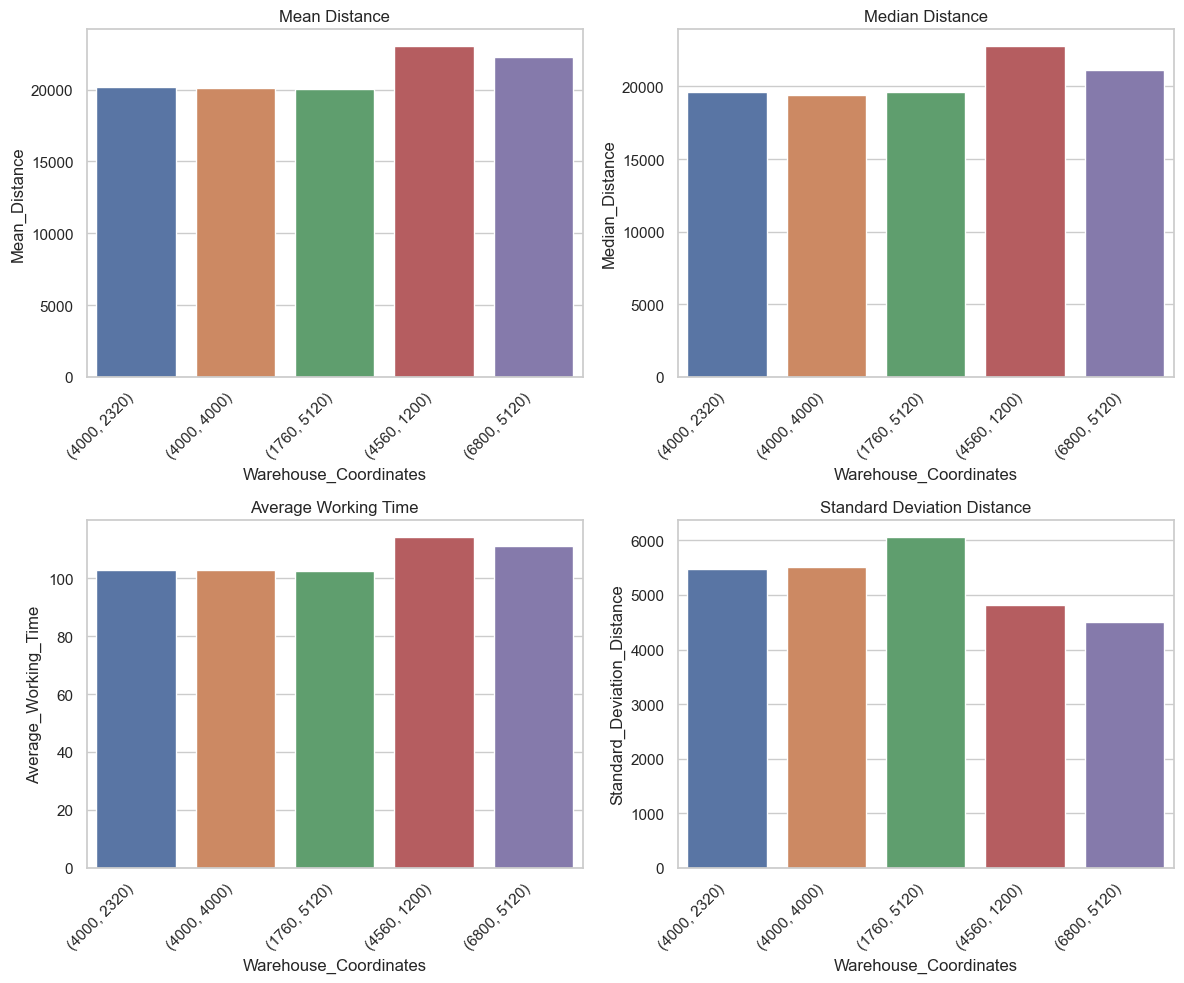

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the figure and axes
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot Mean Distance
sns.barplot(x='Warehouse_Coordinates', y='Mean_Distance', data=results_df, ax=axes[0, 0])
axes[0, 0].set_title('Mean Distance')

# Plot Median Distance
sns.barplot(x='Warehouse_Coordinates', y='Median_Distance', data=results_df, ax=axes[0, 1])
axes[0, 1].set_title('Median Distance')

# Plot Average Working Time
sns.barplot(x='Warehouse_Coordinates', y='Average_Working_Time', data=results_df, ax=axes[1, 0])
axes[1, 0].set_title('Average Working Time')

# Plot Standard Deviation Distance
sns.barplot(x='Warehouse_Coordinates', y='Standard_Deviation_Distance', data=results_df, ax=axes[1, 1])
axes[1, 1].set_title('Standard Deviation Distance')

# Rotate x-axis labels for better readability
for ax in axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


# 7) STATISTICAL MEASURE TO FINALIZE WAREHOUSE

## Multiple Criteria Decision Analysis (MCDA)

In [89]:
import pandas as pd

# Define weights for each criterion (sum of weights should be 1)
weights = {
    'Average_Working_Time': 0.4,
    'Mean_Distance': 0.4,
    'Median_Distance': 0.2,
    'Minimum_Distance': 0.3,
    'Standard_Deviation_Distance': 0.2,
    'Maximum_Distance': 0.1
}

# Normalize weights to ensure they sum up to 1
total_weight = sum(weights.values())
weights = {k: v / total_weight for k, v in weights.items()}

# Calculate the composite score for each warehouse
results_df['Composite_Score'] = 0
for criterion, weight in weights.items():
    results_df['Composite_Score'] += results_df[criterion] * weight

# Rank the warehouses based on composite score
ranked_warehouses = results_df.sort_values(by='Composite_Score', ascending=False)

# Display the ranked warehouses
print(ranked_warehouses[['Warehouse_Coordinates', 'Composite_Score']])

  Warehouse_Coordinates  Composite_Score
3          (4560, 1200)     13965.622606
4          (6800, 5120)     13372.694664
0          (4000, 2320)     12210.381177
1          (4000, 4000)     12035.913338
2          (1760, 5120)     11659.079741


## Visualization MCDA

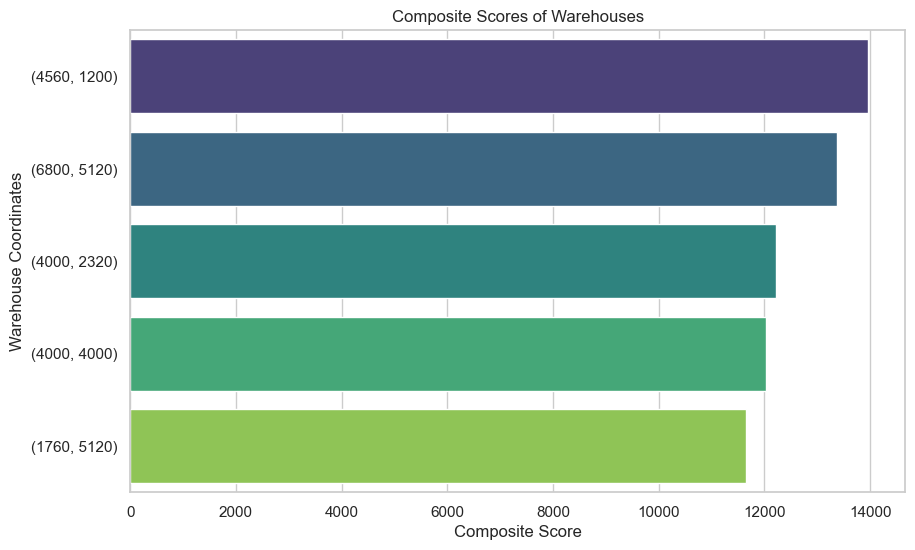

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style
sns.set(style="whitegrid")

# Plotting the composite scores
plt.figure(figsize=(10, 6))
sns.barplot(x='Composite_Score', y='Warehouse_Coordinates', data=ranked_warehouses, palette='viridis')
plt.title('Composite Scores of Warehouses')
plt.xlabel('Composite Score')
plt.ylabel('Warehouse Coordinates')
plt.show()


# 8) RESULTS AND INFERENCE